In [9]:
%config InlineBackend.figure_format = "retina" # nice looking plots

In [13]:
! pip install pymc-marketing

In [16]:
import os

from pymc_marketing import clv
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
raw_transactions = pd.read_gbq(f"SELECT * FROM `{os.getenv('GCP_PROJECT_ID')}.richemont.orders`")
raw_transactions.sample(n=5)

,client_id,transaction_at,total_price,quantity
49151,0011i00000Sz64gAAB,2015-06-24,15858.424764,1
37511,0011i00000YRp51AAD,2016-09-17,6917.279734,1
37576,0011i00000T6E8XAAV,2017-05-31,11519.247328,1
24152,0011i00000YUWIdAAP,2017-03-31,7182.687009,1
36893,0011i00000j8dUxAAI,2016-01-02,6754.538520,1


In [18]:
rfm_data = clv.utils.rfm_summary(
    raw_transactions, 
    customer_id_col = "client_id", 
    datetime_col = "transaction_at", 
    monetary_value_col = "total_price",
    datetime_format = "%Y-%m-%d",
    time_unit = "D")

rfm_data

,customer_id,frequency,recency,T,monetary_value
0,0011i00000S5ZdlAAF,0.0,0.0,454.0,0.0
1,0011i00000S5ZkmAAF,0.0,0.0,62.0,0.0
2,0011i00000S5ZktAAF,0.0,0.0,16.0,0.0
3,0011i00000S5Zl4AAF,0.0,0.0,19.0,0.0
4,0011i00000S5Zl8AAF,0.0,0.0,35.0,0.0
...,...,...,...,...,...
52850,0011i00001k3nI9AAI,0.0,0.0,175.0,0.0
52851,0011i00001k5KSvAAM,0.0,0.0,877.0,0.0
52852,0011i00001kW1Y5AAK,0.0,0.0,851.0,0.0
52853,0011i00001kYivUAAS,0.0,0.0,1032.0,0.0


<Axes: title={'center': 'Customer Exposure'}, xlabel='Time since first purchase', ylabel='Customer'>

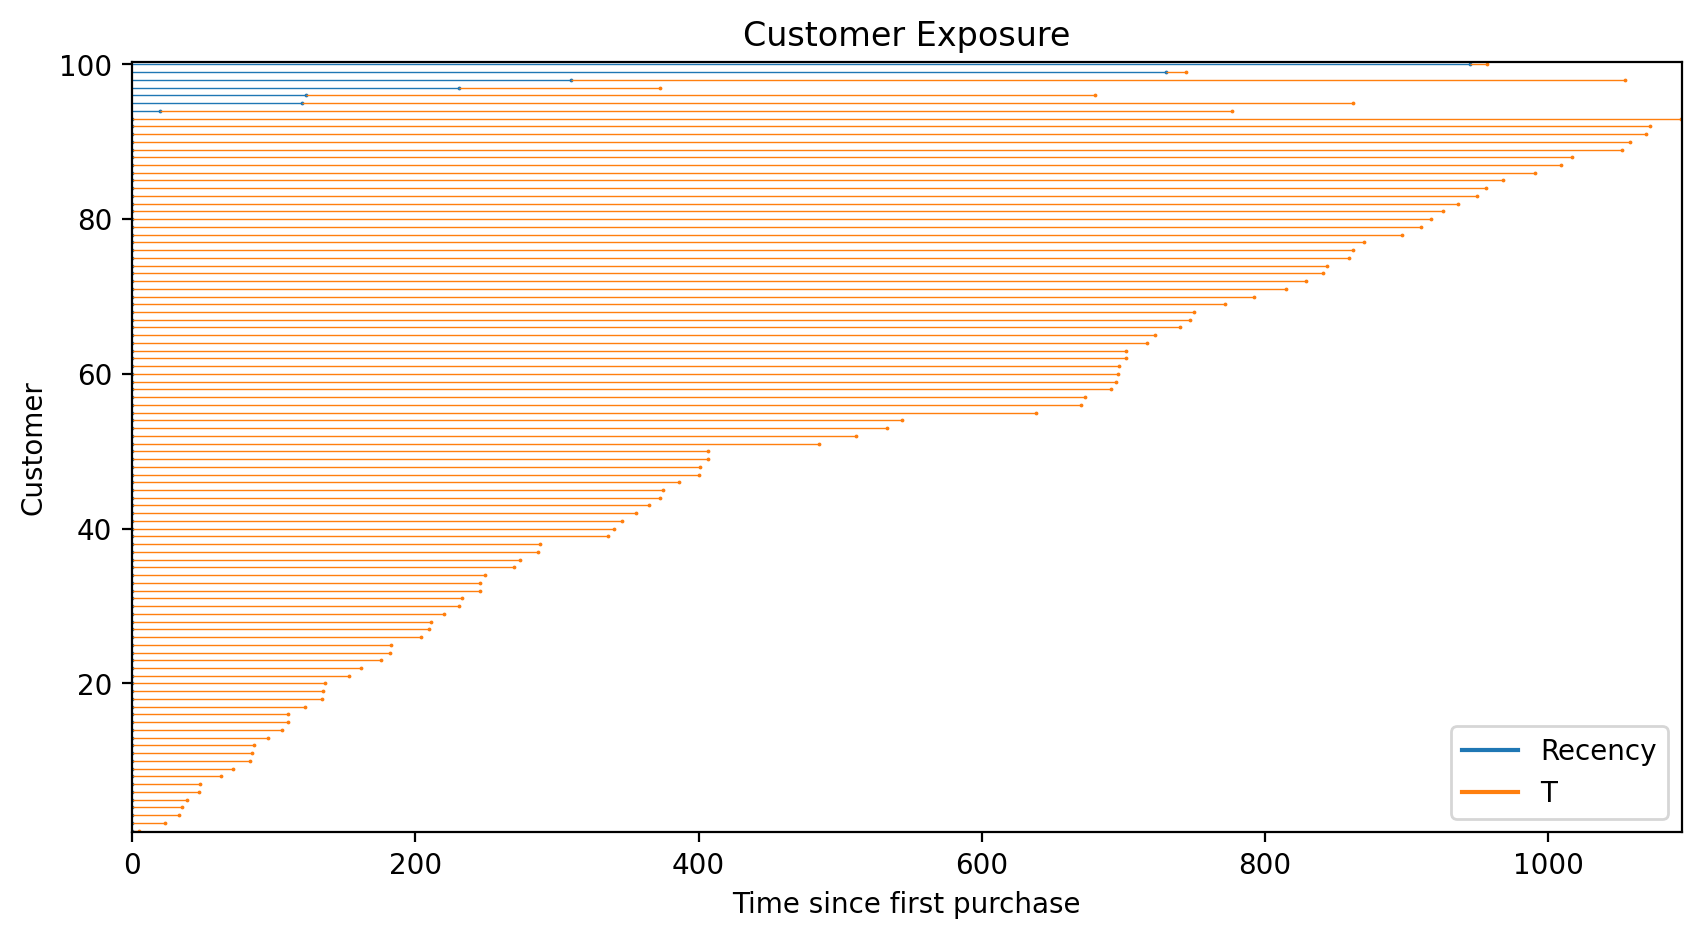

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data
    .sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
)

We see a large chunk (>90%) of customers haven’t made another purchase in a while.

## Basic Frequency/Recency analysis using the BG/NBD model

In [20]:
bgm = clv.BetaGeoModel(
    data = rfm_data
)
bgm.build_model()

In [22]:
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 341 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.493,0.058,0.389,0.609,0.001,0.001,2199.0,1844.0,1.0
b,0.352,0.048,0.258,0.436,0.001,0.001,2206.0,1899.0,1.0
alpha,78.209,5.899,67.548,89.410,0.123,0.087,2276.0,2048.0,1.0
r,0.029,0.001,0.027,0.031,0.000,0.000,2197.0,2131.0,1.0


## Visualizing the Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

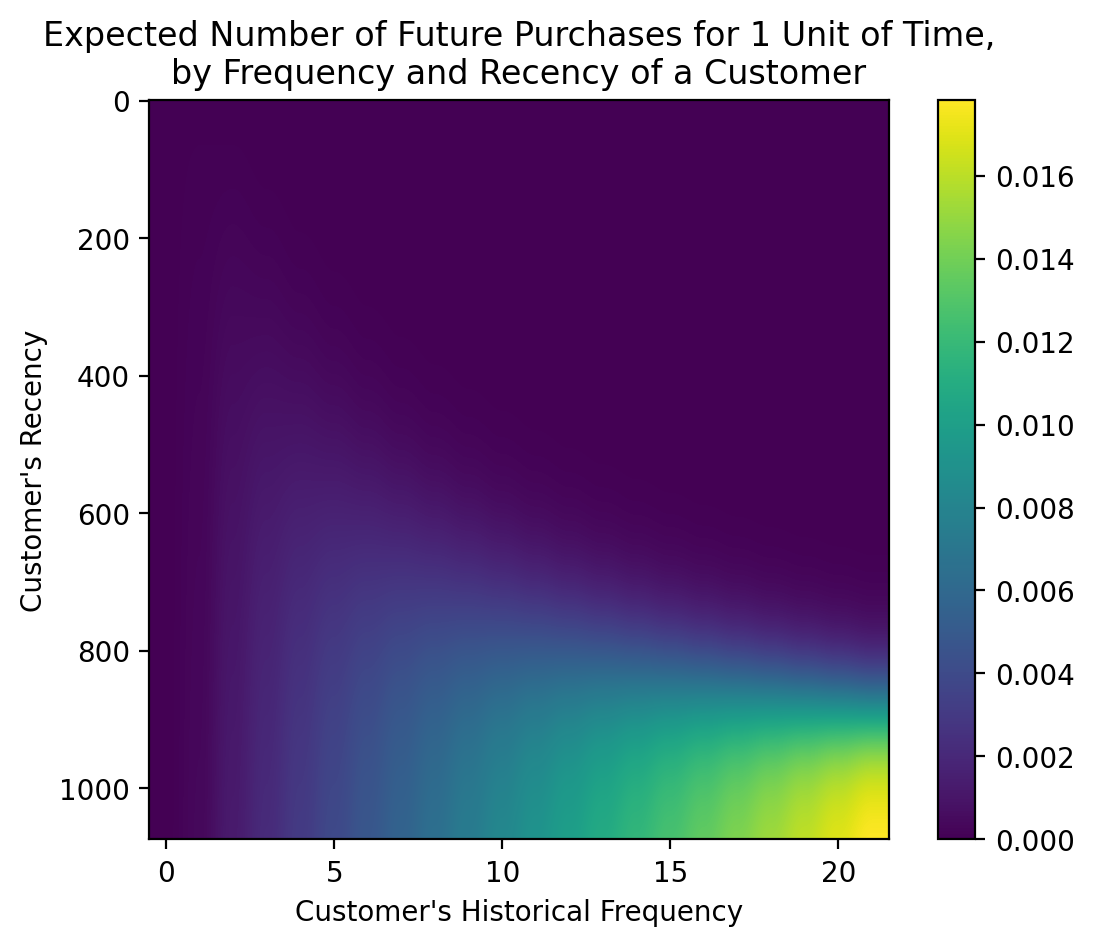

In [23]:
clv.plot_frequency_recency_matrix(bgm)

We can see our best customers have been active for over 60 weeks and have made over 20 purchases (bottom-right). Note the “tail” sweeping up towards the upper-left corner - these customers are infrequent and/or may not have purchased recently. What is the probability they are still active?



<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

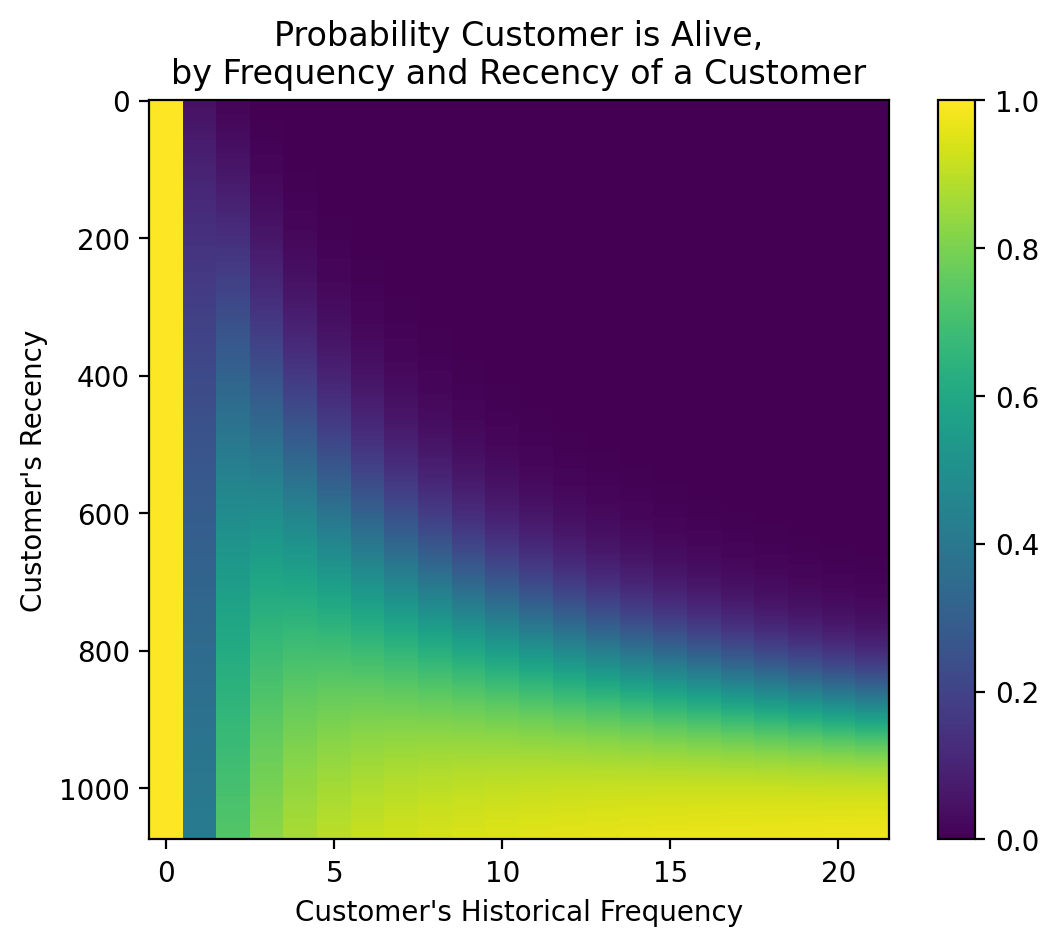

In [24]:
clv.plot_probability_alive_matrix(bgm)

Looking at the probability alive matrix, we can infer that customers who have made fewer purchases are less likely to return, and may be worth targeting for retention.

## Ranking customers from best to worst

Having fit the model, we can ask what is the expected number of purchases for our customers in the next period. Let’s look at the four more promising customers.

In [26]:
num_purchases = bgm.expected_num_purchases(
    customer_id=rfm_data["customer_id"],
    t=30, 
    frequency=rfm_data["frequency"], 
    recency=rfm_data["recency"], 
    T=rfm_data["T"]
)

In [27]:
num_purchases

<xarray.DataArray (chain: 4, draw: 1000, customer_id: 52855)> Size: 2GB
array([[[0.00159287, 0.0059896 , 0.0088745 , ..., 0.00091392,
         0.00076522, 0.00078715],
        [0.00161759, 0.00580131, 0.00834044, ..., 0.00093508,
         0.00078423, 0.00080652],
        [0.00160234, 0.00580363, 0.00839434, ..., 0.00092478,
         0.00077532, 0.00079739],
        ...,
        [0.00157077, 0.00592398, 0.00879544, ..., 0.00090085,
         0.00075421, 0.00077584],
        [0.00157077, 0.00592398, 0.00879544, ..., 0.00090085,
         0.00075421, 0.00077584],
        [0.00158215, 0.00611456, 0.0092304 , ..., 0.00090402,
         0.00075625, 0.00077803]],

       [[0.00159497, 0.0058786 , 0.00859722, ..., 0.00091798,
         0.00076915, 0.00079112],
        [0.00163082, 0.00611689, 0.00904711, ..., 0.00093604,
         0.0007838 , 0.00080626],
        [0.00158702, 0.00570253, 0.00820761, ..., 0.00091712,
         0.00076911, 0.00079097],
...
        [0.00159735, 0.00594154, 0.00874065, ..., 0.00091803,
         0.00076895, 0.00079095],
        [0.0016383 , 0.0057878 , 0.0082454 , ..., 0.00094939,
         0.00079666, 0.00081923],
        [0.00158963, 0.00591575, 0.00870595, ..., 0.00091353,
         0.00076517, 0.00078706]],

       [[0.00161262, 0.00582223, 0.00840501, ..., 0.0009312 ,
         0.00078079, 0.00080301],
        [0.00160721, 0.00555209, 0.00780693, ..., 0.0009349 ,
         0.00078517, 0.00080731],
        [0.00149616, 0.00559684, 0.00826296, ..., 0.0008591 ,
         0.00071944, 0.00074005],
        ...,
        [0.00156579, 0.00596026, 0.00890394, ..., 0.00089671,
         0.0007505 , 0.00077206],
        [0.00155384, 0.00588906, 0.0087716 , ..., 0.00089045,
         0.00074538, 0.00076677],
        [0.00155929, 0.00597378, 0.00896258, ..., 0.00089211,
         0.0007465 , 0.00076797]]])
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * customer_id  (customer_id) object 423kB '0011i00000S5ZdlAAF' ... '0011i00...

In [28]:
sdata = rfm_data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
49662,0011i00000nL6gLAAS,2.0,4.0,4.0,7898.302361,0.501452
50995,0011i00000nLRgRAAW,20.0,1026.0,1058.0,22825.990259,0.502733
51396,0011i00000ngSiIAAU,17.0,716.0,751.0,18257.803791,0.574580
50541,0011i00000nLPKSAA4,21.0,734.0,805.0,19202.468526,0.620857


In [29]:
import arviz as az

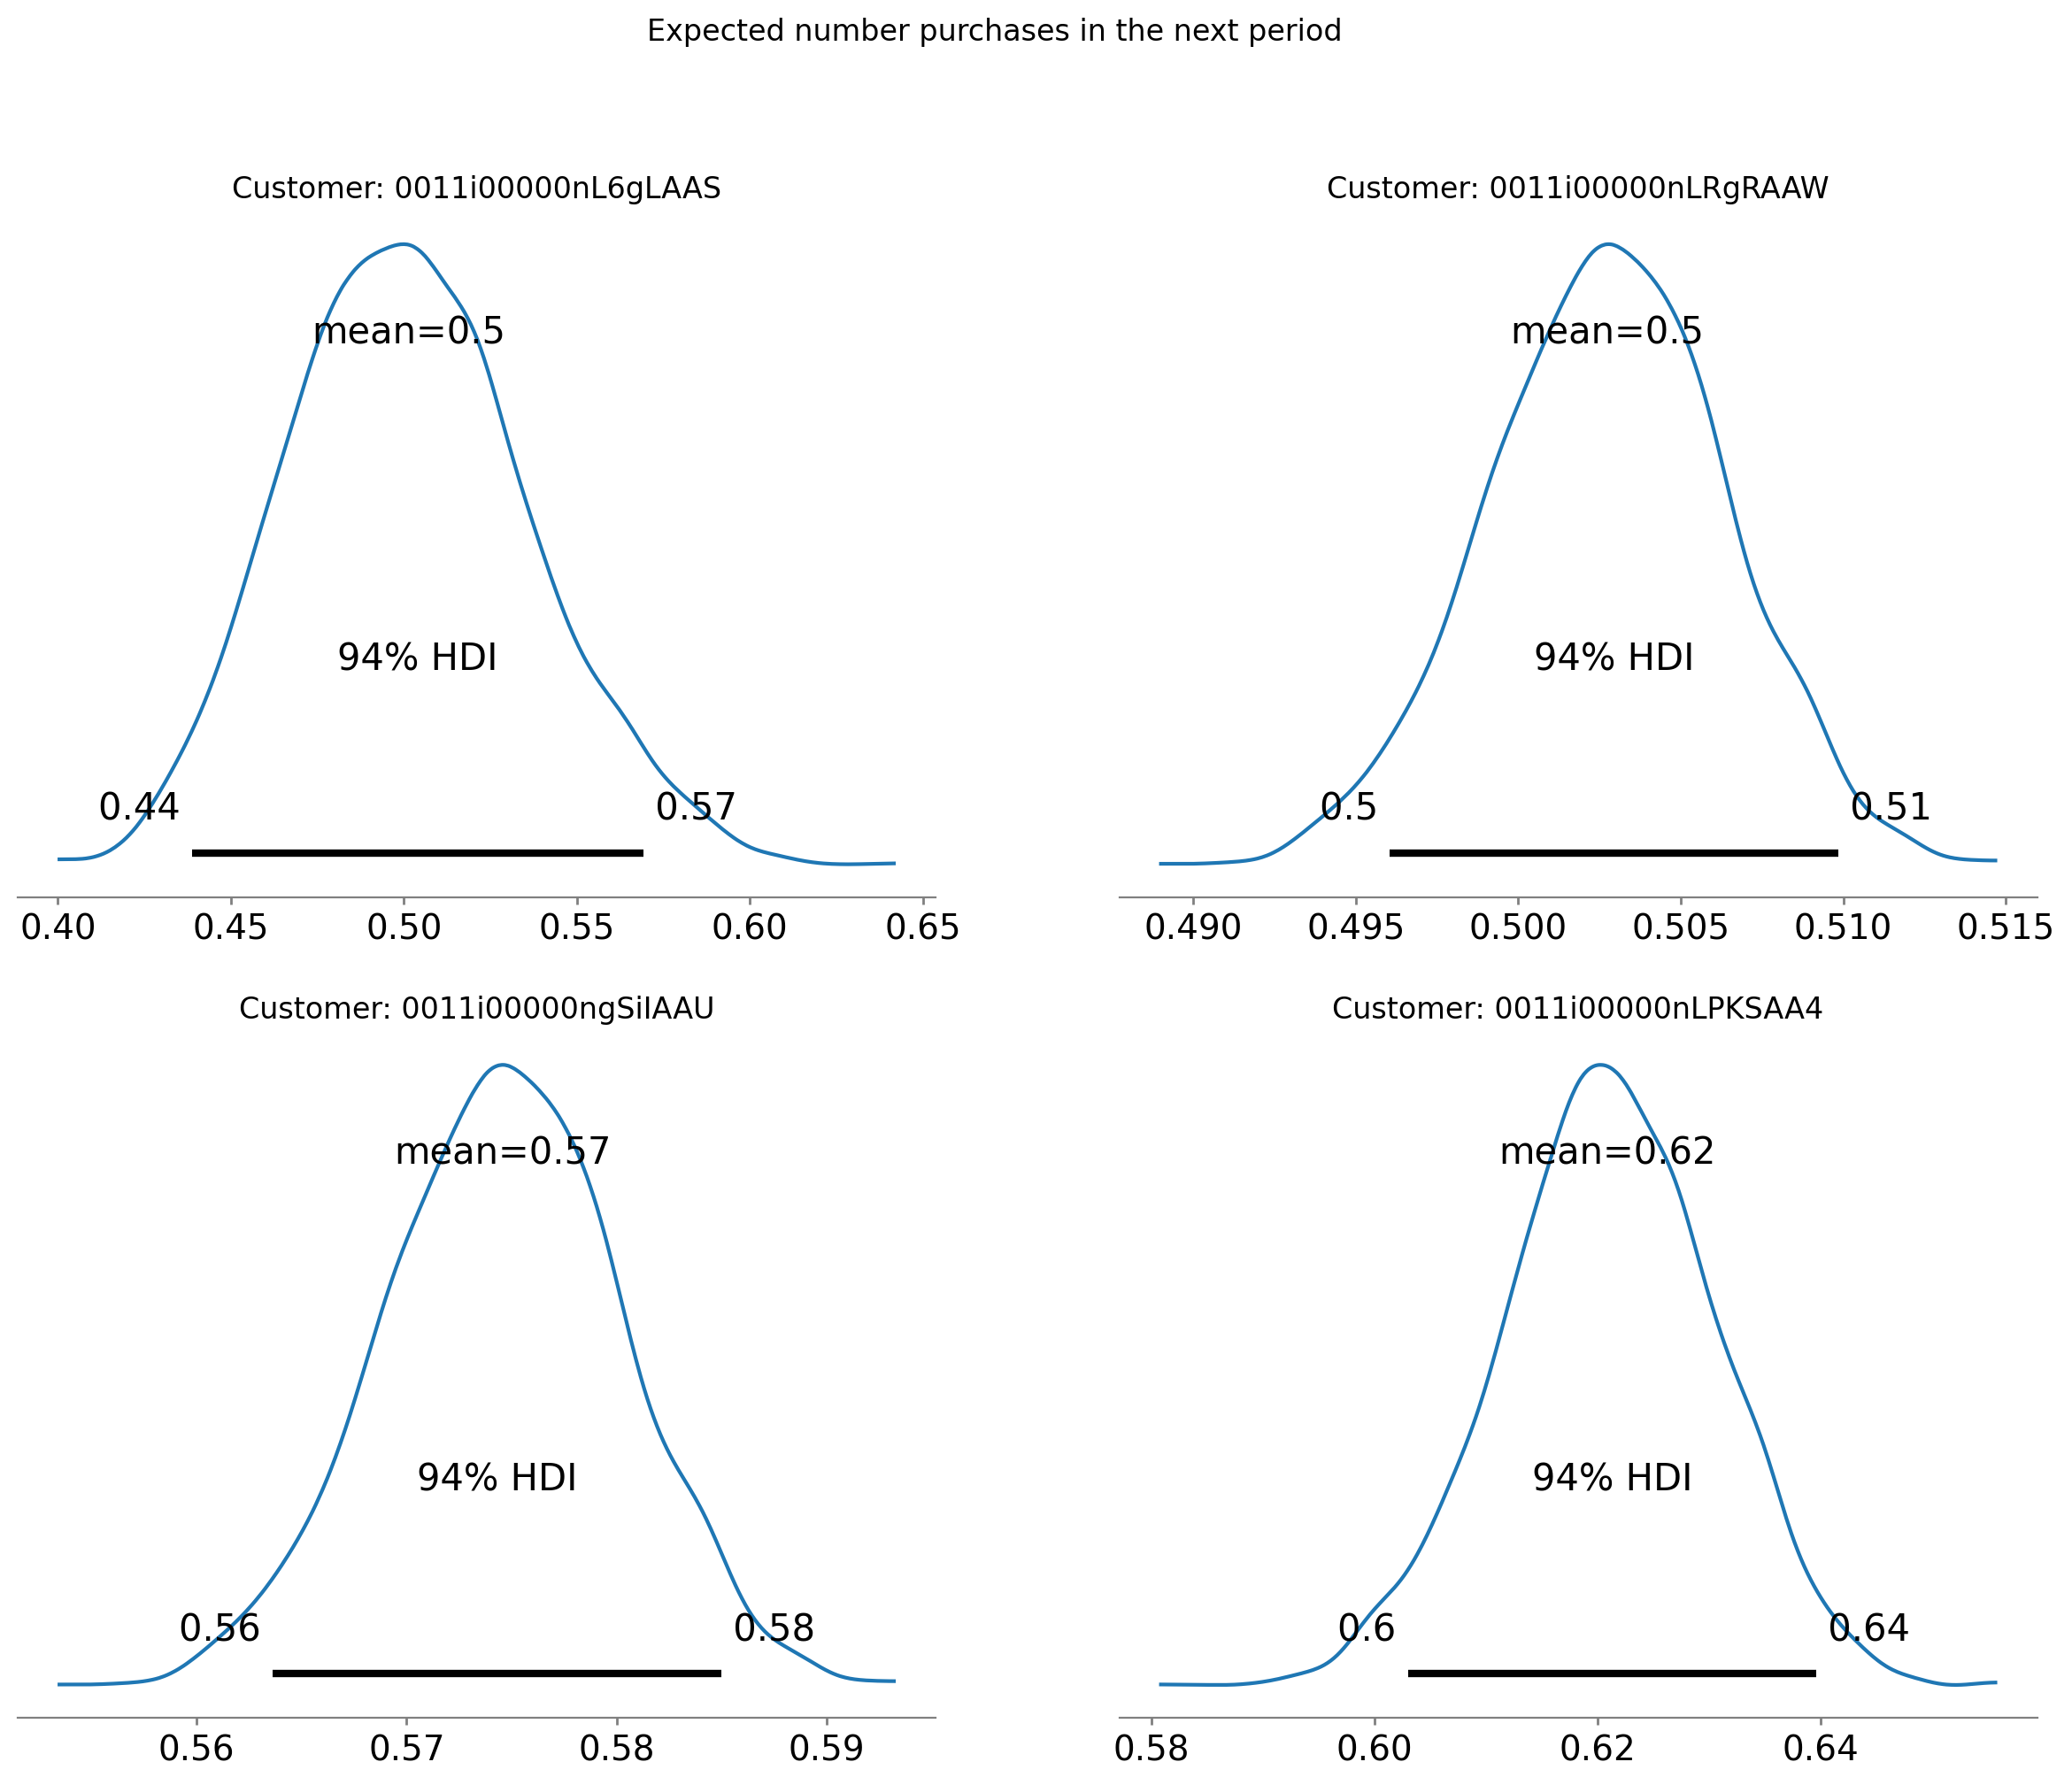

In [32]:
ids = ["0011i00000nL6gLAAS", "0011i00000nLRgRAAW", "0011i00000ngSiIAAU", "0011i00000nLPKSAA4"]

ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));
for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}")
plt.suptitle("Expected number purchases in the next period");

## Predicting purchase behavior of a new customer

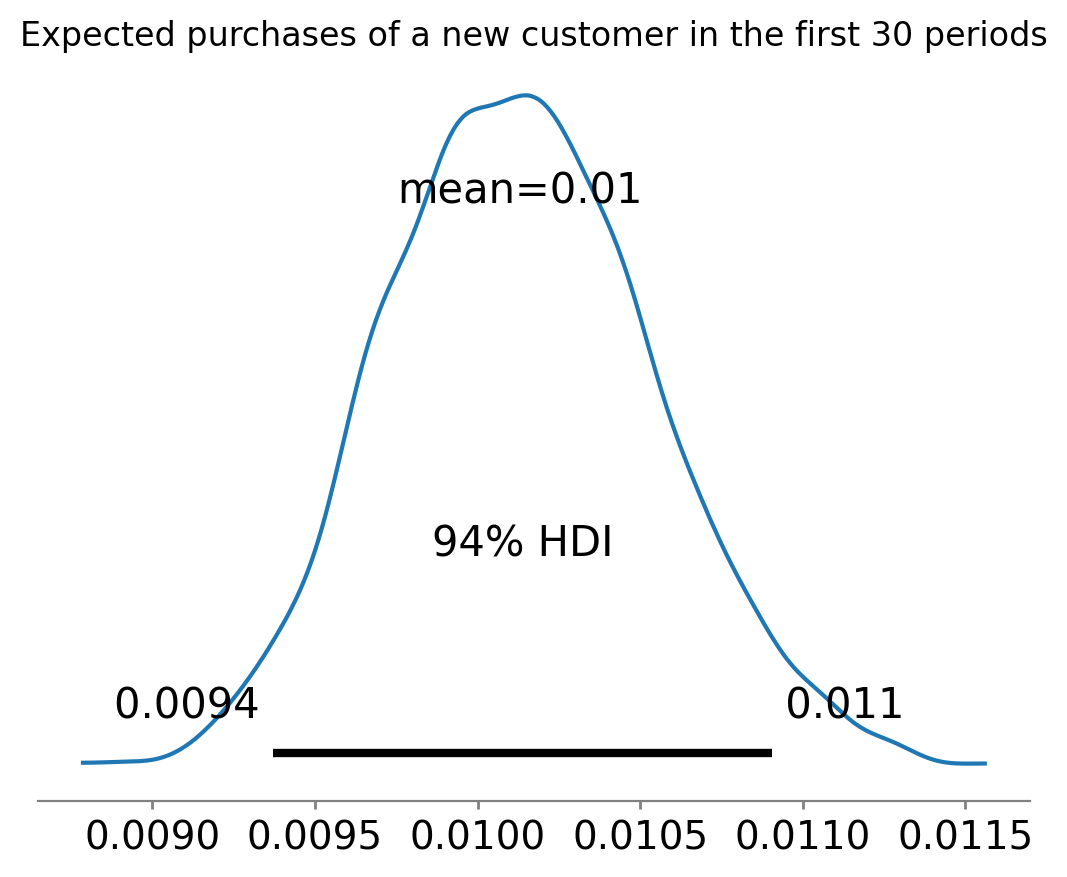

In [35]:
period = 30

az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=period)
)

plt.title(f"Expected purchases of a new customer in the first {period} periods");

## Customer Probability Histories

Let look at a random customer and assess the change in probability that the user will ever return if they do no other purchases in the next 30 time periods.

In [73]:
import random

In [74]:
customer_id = random.choice(list(set(rfm_data[rfm_data["frequency"] > 0]["customer_id"])))

'0011i00000nKDmoAAG'

In [77]:
customer = rfm_data.set_index('customer_id').loc[customer_id]
customer

frequency            1.000000
recency              1.000000
T                  278.000000
monetary_value    4950.658005
Name: 0011i00000j8GLWAA2, dtype: float64

In [68]:
next_period = 30

In [69]:
import numpy as np

In [83]:
customer_history = pd.DataFrame(dict(
    ID=np.full(next_period, customer_id),
    frequency=np.full(next_period, customer["frequency"], dtype="int"),
    recency=np.full(next_period, customer["recency"]),
    T=(np.arange(0, next_period) + customer["recency"]).astype("int"),
    
))
customer_history

,ID,frequency,recency,T
0,0011i00000j8GLWAA2,1,1.0,1
1,0011i00000j8GLWAA2,1,1.0,2
2,0011i00000j8GLWAA2,1,1.0,3
3,0011i00000j8GLWAA2,1,1.0,4
4,0011i00000j8GLWAA2,1,1.0,5
5,0011i00000j8GLWAA2,1,1.0,6
6,0011i00000j8GLWAA2,1,1.0,7
7,0011i00000j8GLWAA2,1,1.0,8
8,0011i00000j8GLWAA2,1,1.0,9
9,0011i00000j8GLWAA2,1,1.0,10


In [84]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_history["ID"],
    frequency=customer_history["frequency"],
    recency=customer_history["recency"],
    T=customer_history["T"],
)

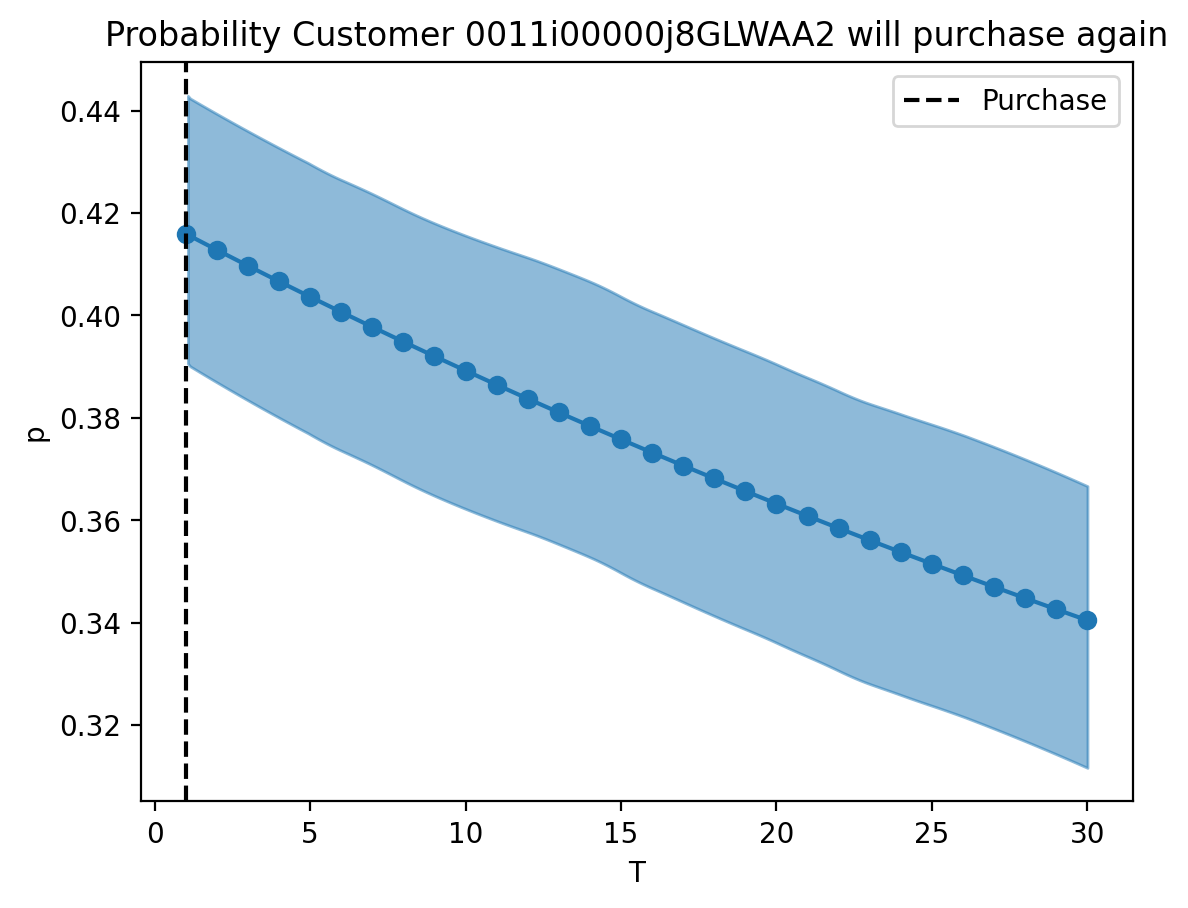

In [85]:
az.plot_hdi(customer_history["T"], p_alive, color="C0")
plt.plot(customer_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title(f"Probability Customer {customer_id} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

## Estimating Customer Lifetime Value Using the Gamma-Gamma Model

Until now we’ve focused mainly on transaction frequencies and probabilities, but to estimate economic value we can use the Gamma-Gamma model.




The Gamma-Gamma model assumes at least 1 repeat transaction has been observed per customer. As such we filter out those with zero repeat purchases.



In [86]:
nonzero_data = rfm_data.query("frequency>0")
nonzero_data

,customer_id,frequency,recency,T,monetary_value
85,0011i00000S5c6uAAB,2.0,15.0,714.0,11381.720730
90,0011i00000S5c8EAAR,2.0,331.0,858.0,25268.150548
91,0011i00000S5c8IAAR,1.0,50.0,425.0,19138.277945
93,0011i00000S5c8MAAR,1.0,487.0,853.0,15783.672238
128,0011i00000S5cKFAAZ,2.0,607.0,1019.0,41002.921527
...,...,...,...,...,...
52818,0011i00001dOL9cAAG,1.0,16.0,241.0,10465.746504
52822,0011i00001fU4XEAA0,1.0,591.0,1051.0,13437.060727
52826,0011i00001fuyJWAAY,1.0,397.0,800.0,7646.244630
52839,0011i00001ibr8QAAQ,1.0,31.0,852.0,10283.555486


In [87]:
nonzero_data[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.000000,0.063148
frequency,0.063148,1.000000


Transaction frequencies and monetary values are uncorrelated; we can now fit our Gamma-Gamma model to predict average spend and expected lifetime values of our customers

In [88]:
dataset = pd.DataFrame({
    'customer_id': nonzero_data.index,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})

In [89]:
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [97]:
gg.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1190 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [98]:
expected_spend = gg.expected_customer_spend(
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
)

In [99]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")


,mean,sd,hdi_3%,hdi_97%
x[0],12979.701,84.163,12893.433,13117.589
x[1],12979.701,84.163,12893.433,13117.589
x[2],12979.701,84.163,12893.433,13117.589
x[3],12979.701,84.163,12893.433,13117.589
x[4],12979.701,84.163,12893.433,13117.589
x[5],12979.701,84.163,12893.433,13117.589
x[6],12979.701,84.163,12893.433,13117.589
x[7],12979.701,84.163,12893.433,13117.589
x[8],12979.701,84.163,12893.433,13117.589
x[9],12979.701,84.163,12893.433,13117.589


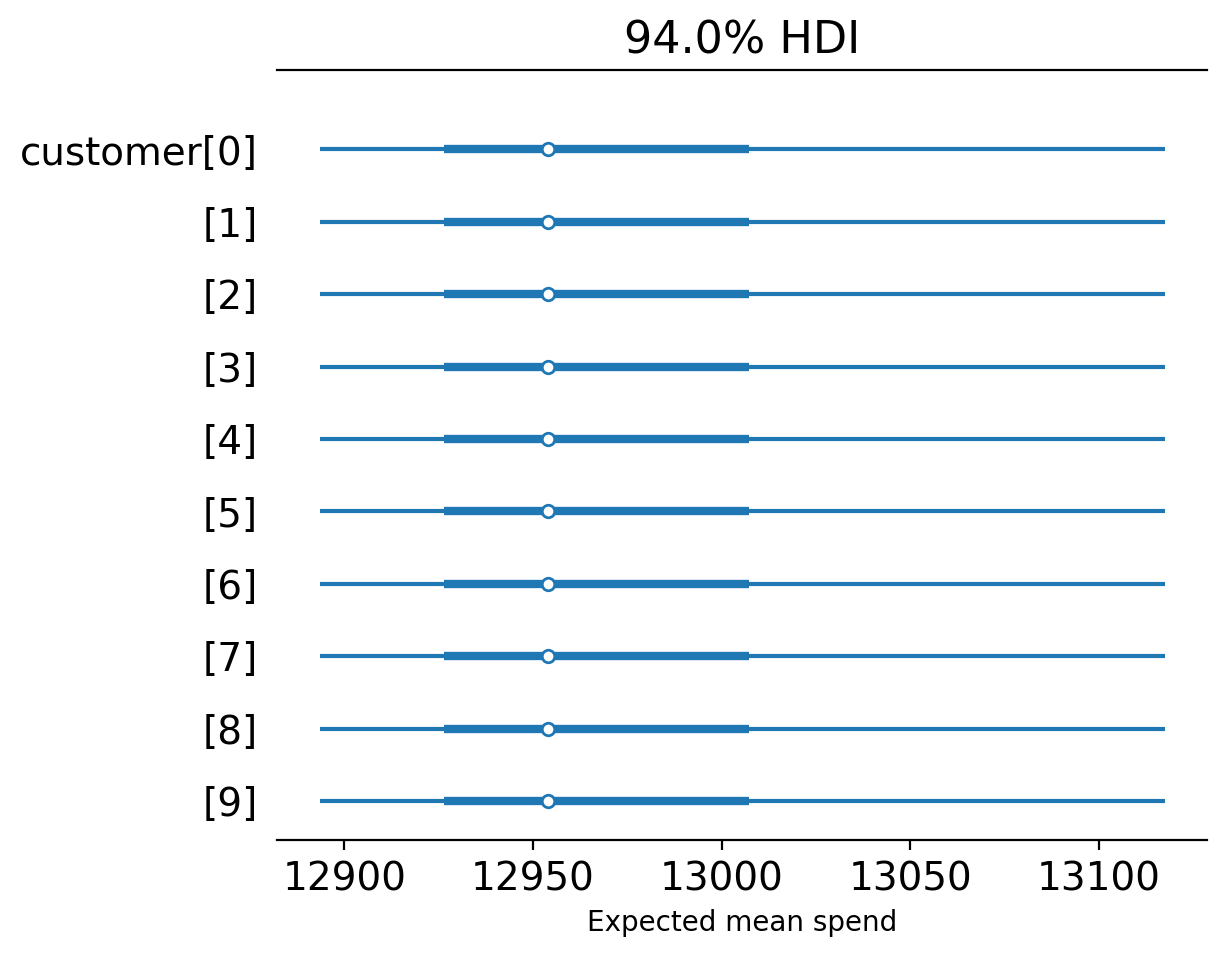

In [100]:
from arviz.labels import MapLabeller

labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)
plt.xlabel("Expected mean spend");


We can also look at the average expected mean spend across all customers



In [103]:
az.summary(expected_spend.mean('customer_id'), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,13005.336,79.757,12923.584,13136.006


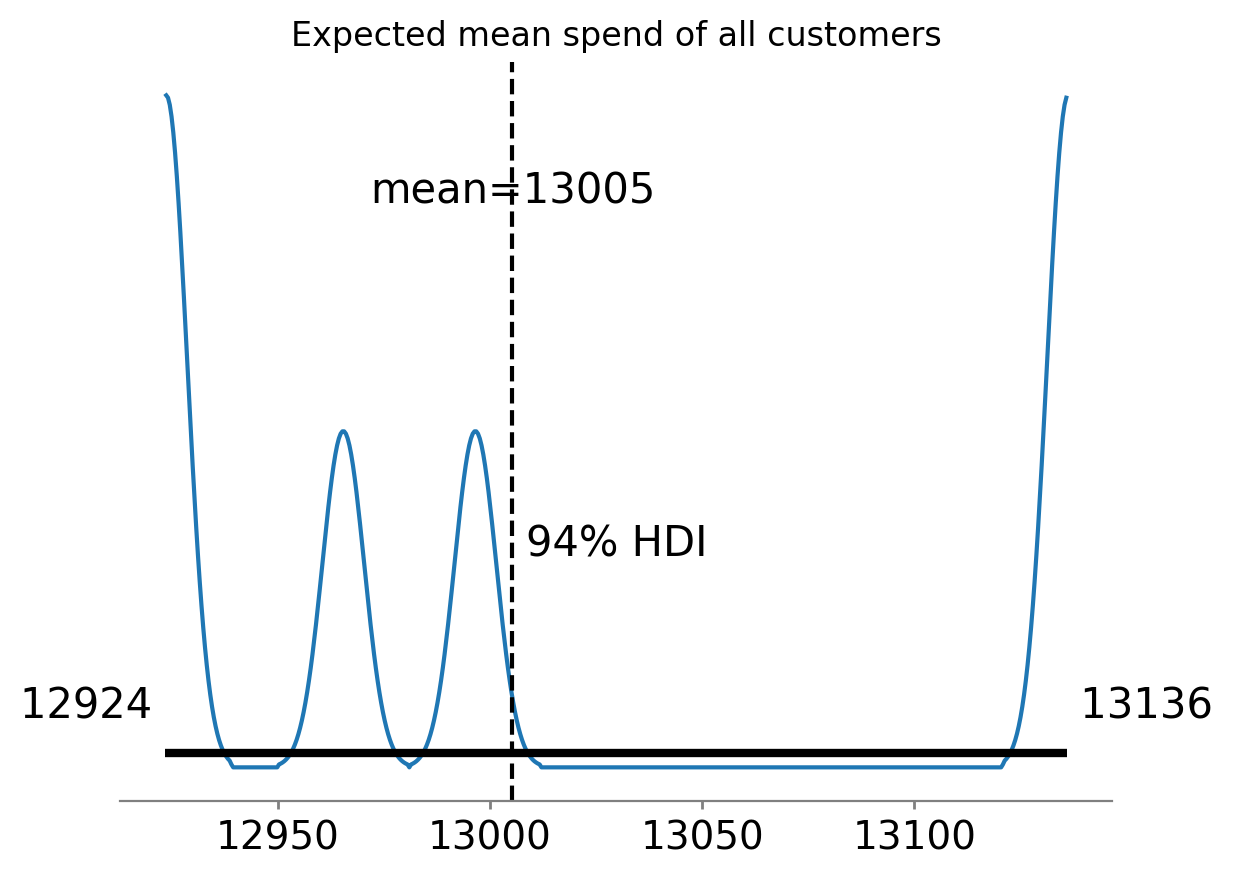

In [107]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");